In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from subcell_analysis.compression_analysis import COMPRESSIONMETRIC
from subcell_analysis.compression_workflow_runner import compression_metrics_workflow

from pathlib import Path

Set parameters

In [2]:
readdy_compression_velocities = [4.7, 15, 47, 150]
# cytosim_compression_velocities = [0.15, 0.47434165, 1.5, 4.73413649, 15, 47.4341649, 150]
cytosim_compression_velocities = [0.15, 0.47434165, 1.5, 4.7, 15, 47, 150]

In [3]:
metrics =  [COMPRESSIONMETRIC.NON_COPLANARITY, COMPRESSIONMETRIC.PEAK_ASYMMETRY, COMPRESSIONMETRIC.TOTAL_FIBER_TWIST]

### Process cytosim data

In [4]:
df_path = Path("/allen/aics/animated-cell/Saurabh/subcell-analysis/data/dataframes")

In [5]:
num_repeats = 5
velocity_inds = range(3, 7)
df_metrics = []
for index in velocity_inds:
    for repeat in range(num_repeats):
        print(f"Calculating metrics for velocity {cytosim_compression_velocities[index]} and repeat {repeat}")
        df = pd.read_csv(f"{df_path}/cytosim_actin_compression_velocity_vary_compress_rate000{index}_repeat_{repeat}.csv")
        df = compression_metrics_workflow(df, metrics)
        metric_df = df.groupby("time")[[metric.value for metric in metrics]].mean().reset_index()
        metric_df["velocity"] = cytosim_compression_velocities[index]
        metric_df["repeat"] = repeat
        df_metrics.append(metric_df)
        # break
    # break
df_cytosim = pd.concat(df_metrics)
df_cytosim.to_csv(f"{df_path}/cytosim_actin_compression_metrics_all_velocities_and_repeats.csv")

Calculating metrics for velocity 4.7 and repeat 0
Calculating metrics for velocity 4.7 and repeat 1
Calculating metrics for velocity 4.7 and repeat 2
Calculating metrics for velocity 4.7 and repeat 3
Calculating metrics for velocity 4.7 and repeat 4
Calculating metrics for velocity 15 and repeat 0
Calculating metrics for velocity 15 and repeat 1
Calculating metrics for velocity 15 and repeat 2
Calculating metrics for velocity 15 and repeat 3
Calculating metrics for velocity 15 and repeat 4
Calculating metrics for velocity 47 and repeat 0
Calculating metrics for velocity 47 and repeat 1
Calculating metrics for velocity 47 and repeat 2
Calculating metrics for velocity 47 and repeat 3
Calculating metrics for velocity 47 and repeat 4
Calculating metrics for velocity 150 and repeat 0
Calculating metrics for velocity 150 and repeat 1
Calculating metrics for velocity 150 and repeat 2
Calculating metrics for velocity 150 and repeat 3
Calculating metrics for velocity 150 and repeat 4


Load from saved data

In [ ]:
df_cytosim = pd.read_csv(f"{df_path}/cytosim_actin_compression_metrics_all_velocities_and_repeats.csv")

### Process readdy data

In [6]:
num_repeats = 3
df_metrics = []
for velocity in readdy_compression_velocities:
    for repeat in range(num_repeats):
        file_path = df_path / f"readdy_actin_compression_velocity_{velocity}_repeat_{repeat}.csv"
        if file_path.is_file():
            df = pd.read_csv(file_path)
        else:
            continue
        print(f"Calculating metrics for velocity {velocity} and repeat {repeat}")
        df = compression_metrics_workflow(df, metrics)
        metric_df = df.groupby("time")[[metric.value for metric in metrics]].mean().reset_index()
        metric_df["velocity"] = velocity
        metric_df["repeat"] = repeat
        df_metrics.append(metric_df)

df_readdy = pd.concat(df_metrics)
df_readdy.to_csv(f"{df_path}/readdy_actin_compression_metrics_all_velocities_and_repeats.csv")

Calculating metrics for velocity 4.7 and repeat 0
Calculating metrics for velocity 4.7 and repeat 1
Calculating metrics for velocity 4.7 and repeat 2
Calculating metrics for velocity 15 and repeat 0
Calculating metrics for velocity 15 and repeat 1
Calculating metrics for velocity 47 and repeat 0
Calculating metrics for velocity 47 and repeat 1
Calculating metrics for velocity 47 and repeat 2
Calculating metrics for velocity 150 and repeat 0
Calculating metrics for velocity 150 and repeat 1
Calculating metrics for velocity 150 and repeat 2


Load from saved data

In [ ]:
df_readdy = pd.read_csv(f"{df_path}/readdy_actin_compression_metrics_all_velocities_and_repeats.csv")

Rename readdy outputs

In [ ]:
df_path = Path("/allen/aics/animated-cell/Saurabh/subcell-analysis/data/dataframes")

In [ ]:
for f in df_path.glob("actin_compression_velocity=*"):
    fname = f.name
    index = fname.split(".")[-2]
    base_name = f"readdy_{fname}".replace("=", "_").split(".")[0]
    f.rename(f.parent / f"{base_name}_repeat_{index}.csv")
    

Plot metrics for readdy and cytosim

In [7]:
figure_path = Path("/allen/aics/animated-cell/Saurabh/subcell-analysis/figures")

In [8]:
df_cytosim["simulator"] = "cytosim"
df_readdy["simulator"] = "readdy"

In [9]:
df_combined = pd.concat([df_cytosim, df_readdy])

In [10]:
color_map = {
    "cytosim": "C0",
    "readdy": "C1"
}

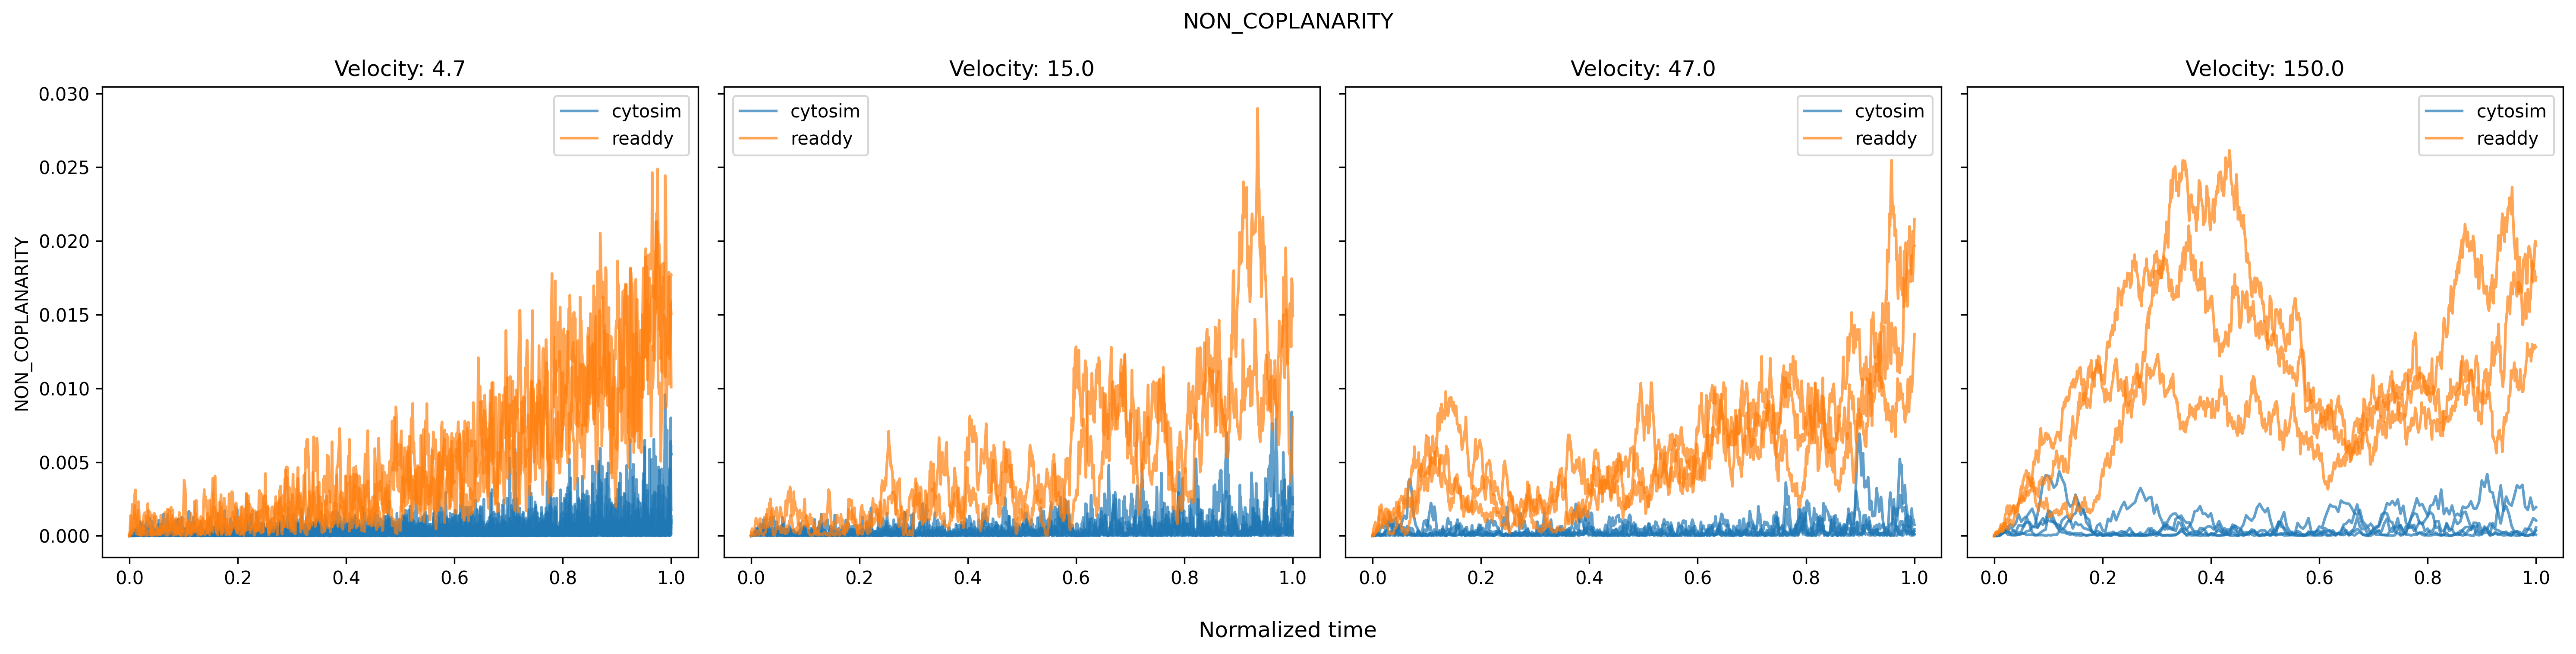

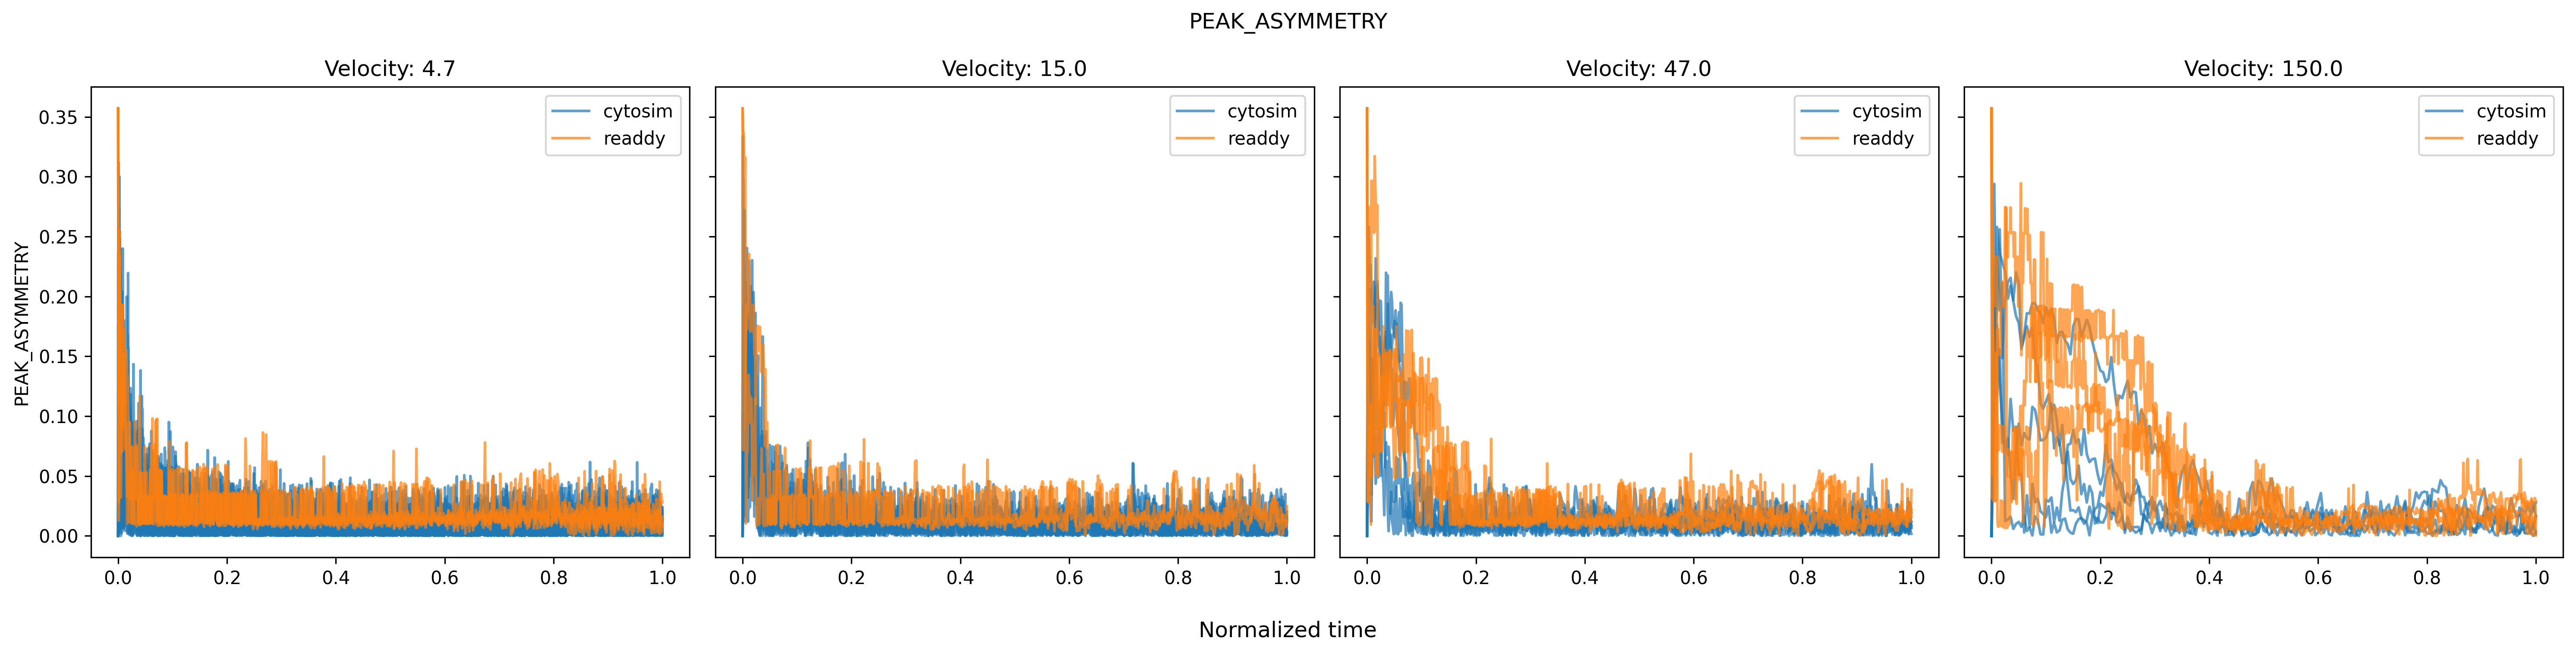

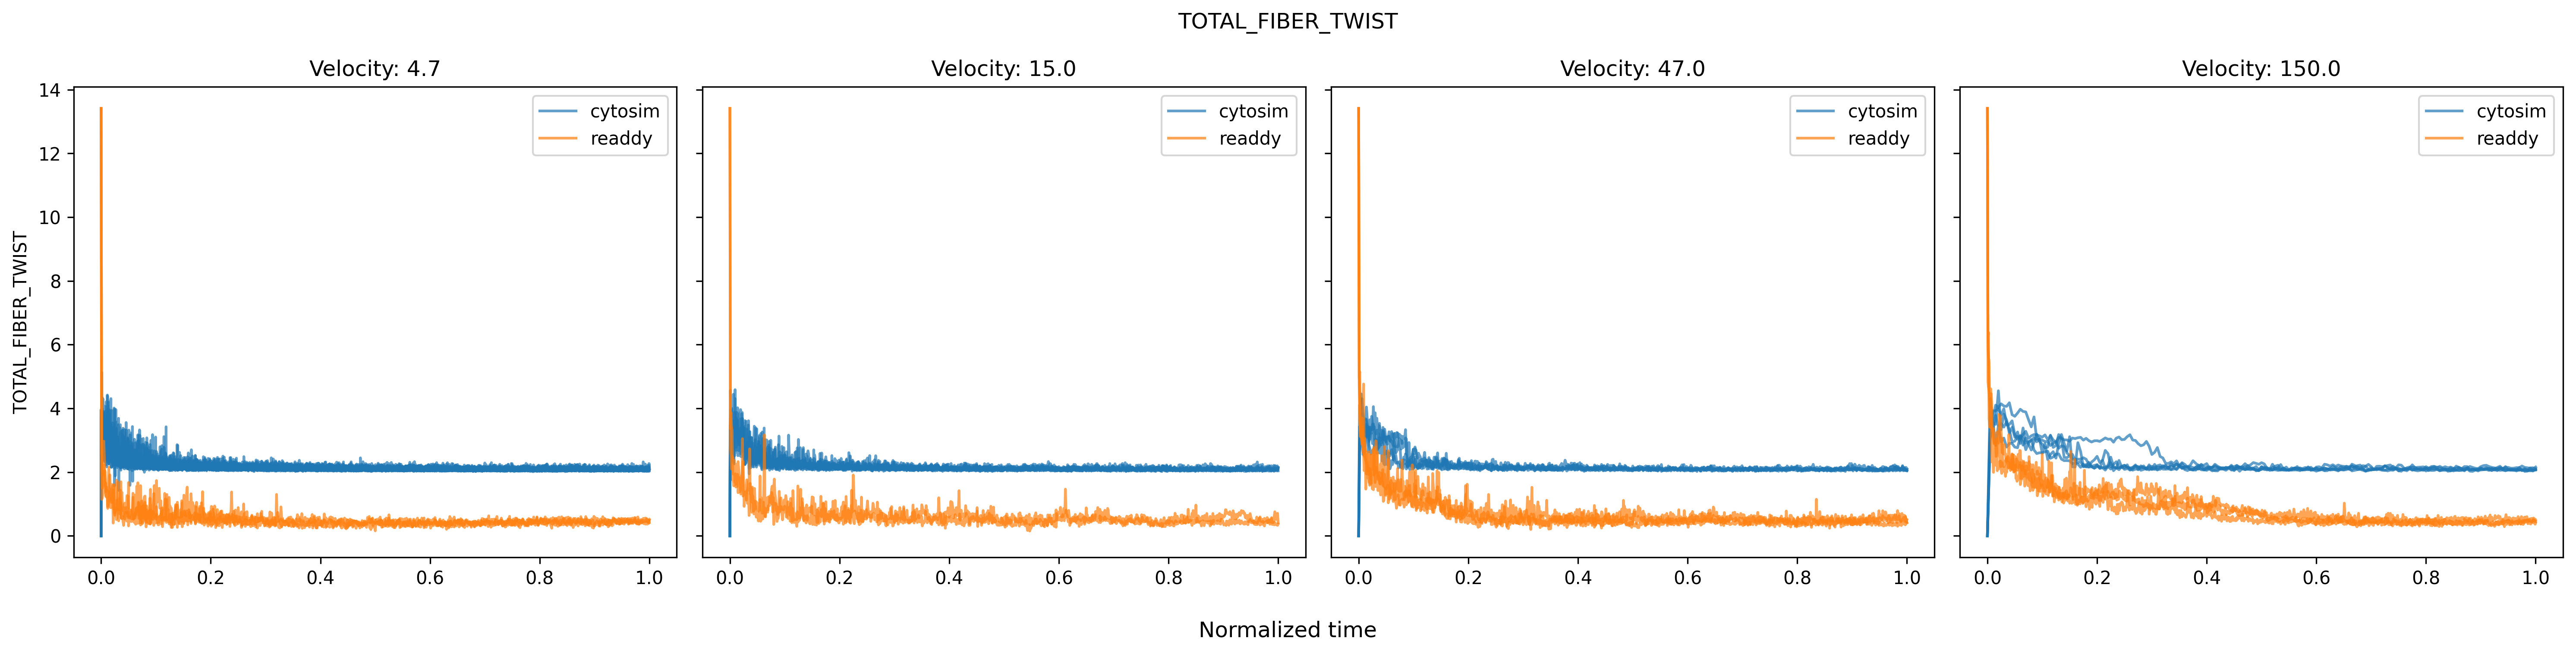

In [11]:
num_velocities = df_combined["velocity"].nunique()
for metric in metrics:
    fig, axs = plt.subplots(1, num_velocities, figsize=(num_velocities * 5, 5), sharey=True, dpi=300)
    for ct, (velocity, df_velocity) in enumerate(df_combined.groupby("velocity")):
        for simulator, df_simulator in df_velocity.groupby("simulator"):
            for repeat, df_repeat in df_simulator.groupby("repeat"):
                # print(f"Velocity: {velocity}, simulator: {simulator}, repeat: {repeat}, min time: {df_repeat['time'].min()}, max time: {df_repeat['time'].max()}, nsteps: {len(df_repeat)}")
                if repeat == 0:
                    label = f"{simulator}"
                else:
                    label = "_nolegend_"
                axs[ct].plot(
                    np.linspace(0, 1, len(df_repeat)),
                    # df_repeat["time"] * time_scale,
                    df_repeat[metric.value],
                    label=label,
                    color=color_map[simulator],
                    alpha=0.7,
                )
        axs[ct].legend()
        axs[ct].set_title(f"Velocity: {velocity}")
        if ct == 0:
            axs[ct].set_ylabel(metric.value)
    fig.supxlabel("Normalized time")
    fig.suptitle(f"{metric.value}")
    plt.tight_layout()
    fig.savefig(figure_path / f"all_simulators_{metric.value}_vs_time.png")

In [15]:
df_readdy.groupby(["velocity", "repeat"]).agg("size")

velocity  repeat
4.7       0         1001
          1         1001
          2         1001
15.0      0         1001
          1         1001
47.0      0         1001
          1         1001
          2         1001
150.0     0         1001
          1         1001
          2         1001
dtype: int64

In [16]:
df_cytosim.groupby(["velocity", "repeat"]).agg("size")

velocity  repeat
4.7       0         6338
          1         6338
          2         6338
          3         6338
          4         6338
15.0      0         2001
          1         2001
          2         2001
          3         2001
          4         2001
47.0      0          633
          1          633
          2          633
          3          633
          4          633
150.0     0          201
          1          201
          2          201
          3          201
          4          201
dtype: int64